In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load in selection function

In [6]:
# Apply Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr2_sf = CoGii.dr3_sf(version='modelAB',crowding=False)

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.456 s
  auxilliary:   4.454 s
          sf:   0.002 s
interpolator:   0.001 s
Loading auxilliary data ...


In [8]:
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

# M = 85; C = 1; j=[-1,0,1,2,3,4]; lengthscale=0.3; nside=32
# map_fname = f"chisquare_j{str(j).replace(' ','')}_nside{nside}_M{M}_C1_l0.3_results.h5"
# M = 214; C = 1; jmax=4; lengthscale=0.3; nside=32
# map_fname = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C1_l0.3_B2.0_ncores40mp_lbfgsb_scipy_results.h5"
# M = 21; C = 1; jmax=4; lengthscale=0.3; nside=32
# map_fname = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C1_l0.3_B2.0_ncores20mp_lbfgsb_scipy_results.h5"

M = 102; C = 1; jmax=5; lengthscale_m=0.3; lengthscale_c=200.0; nside=64
map_fname = f"chisquare_ruwe1p4_jmax{jmax}_nside{nside}_M{M}_CGR1_lm{lengthscale_m}lc{lengthscale_c}_B2.0_ncores88_scipy_results.h5"

ast_sf = chisel(map_fname=map_fname, nside=64, C=C, M=M, basis_options={'needlet':'chisquare', 'j':jmax, 'B':2.0, 'p':1.0, 'wavelet_tol':1e-2},
                       spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                       bounds=False)

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 2.521 s
  auxilliary:   0.062 s
          sf:   0.000 s
interpolator:   2.459 s


Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4].h5
Spherical basis file loaded
t = 0.597 s
  auxilliary:   0.017 s
          sf:   0.000 s
interpolator:   0.580 s


# Apply selection function

In [9]:
m = np.arange(1.6,23.,0.01)
l = np.random.rand(len(m))+2*np.pi
b = np.zeros(len(m)) + np.pi/2

In [10]:
gaiasf = sf_utils.apply_subgaiasf(l, b, m, dr2_sf=dr2_sf, get_prob=True)[1]

Gaia SF prob
Sub SF prob


In [11]:
astsf = sf_utils.apply_subgaiasf(l, b, m, dr2_sf=dr2_sf, sub_sf=ast_sf)[1]

Gaia SF prob
Sub SF prob


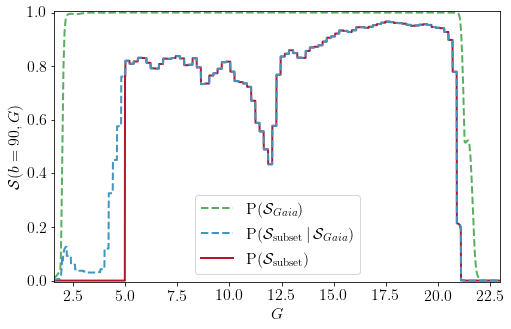

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

plt.plot(m, gaiasf, label=r"$\mathrm{P}(\mathcal{S}_{Gaia})$",
        c=cm.PRGn(0.8), linestyle='--', linewidth=2)
plt.plot(m, astsf, zorder=2, 
         label=r"$\mathrm{P}(\mathcal{S}_\mathrm{subset}\,|\,\mathcal{S}_{Gaia})$",
         c=cm.RdBu(0.8) , linewidth=2, linestyle='--')

combined = astsf*gaiasf; combined[m<=5]=0
plt.plot(m, combined, label=r"$\mathrm{P}(\mathcal{S}_\mathrm{subset})$", zorder=1,
        c=cm.RdBu(0.1), linestyle='-', linewidth=2)

plt.ylabel(r'$\mathcal{S}(b=90, G)$')

plt.xlabel(r'$G$')
plt.ylim(-0.007, 1.007); plt.xlim(m[0], m[-1])

plt.legend(loc="lower center")

plt.savefig(f'figs/edr3-ruwe_SF_G.png', bbox_inches='tight', facecolor='w', transparent=False)

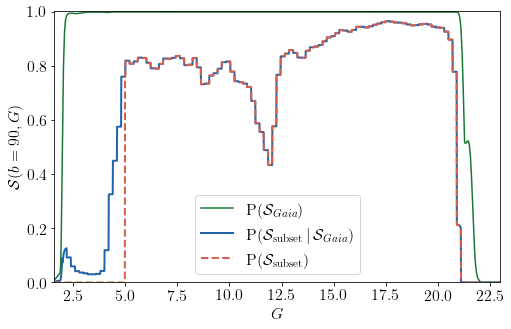